# Initial setup

In [10]:
## Setup the path for our codebase
import sys
sys.path.append( '../code/' )

In [12]:
## import our time_series codebase
import time_series.generated_datasets
import time_series.result_set
import time_series.algorithm

In [17]:
dataset_0 = time_series.generated_datasets.DSS[0]( 10 )

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

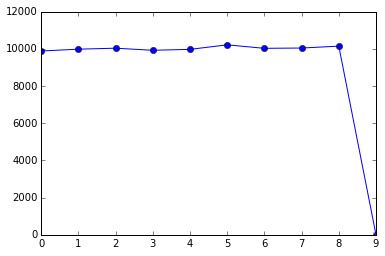

In [19]:
time_series.generated_datasets.plot_dataset( dataset_0 )

# Ploynomial Least-Squares Fit Algorithm

In [20]:
## import numpy for polyfit
import numpy as np

In [36]:
##
# Define a new algorithm for a polynomial least-squares fit
class PolyFitAlg( time_series.algorithm.AlertAlgorithm):
    def __init__(self, order):
        self.order = order
        time_series.algorithm.AlertAlgorithm.__init__( self, "Polyfit[{0}]".format(order) )
    def __call__( self, target, history ):
        # fit the polynomail to history
        n = len(history)
        poly = np.poly1d( np.polyfit( xrange(n), history, self.order ) )
        expected = poly(n)
        difference = abs(target - expected)
        if target != 0:
            fraction = difference / abs(target)
        else:
            # Assume target is actuall 1, so absolute difference instead of fraction
            fraction = difference
        result = {
            'target' : target,
            'expected' : expected,
            'order' : self.order,
            'difference' : difference,
            'fraction' : fraction,
            'poly' : poly,
        }
        return fraction, result

In [37]:
alg_pf = PolyFitAlg( 4 )
frac, res = alg_pf( 10.0, xrange(10) )


In [38]:
res

{'difference': 7.1054273576010019e-15,
 'expected': 10.000000000000007,
 'fraction': 7.1054273576010023e-16,
 'order': 4,
 'poly': poly1d([  1.44304281e-17,  -2.37052649e-16,   1.12971061e-15,
          1.00000000e+00,  -7.02166694e-16]),
 'target': 10.0}

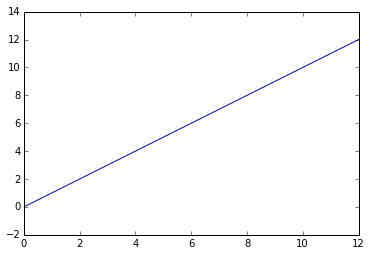

In [40]:
plt.plot( xrange(13), res['poly']( xrange(13) ))

In [44]:
frac,res = alg_pf( dataset_0.time_series[-1], dataset_0.time_series[:-1] )
res

{'difference': 10154.187259252602,
 'expected': 10154.187259252602,
 'fraction': 10154.187259252602,
 'order': 4,
 'poly': poly1d([ -3.02650746e-02,   1.06285382e+00,  -1.07306833e+01,
          6.08969483e+01,   9.89904879e+03]),
 'target': 0.0}

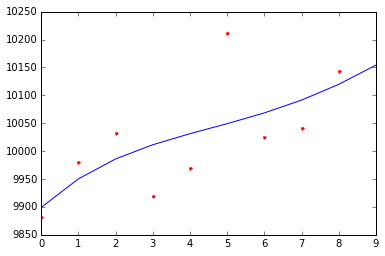

In [47]:
n = len(dataset_0.time_series)
plt.plot( xrange(n), res['poly']( xrange(n)) )
plt.hold( True )
plt.plot( xrange(n-1), dataset_0.time_series[:-1], 'r.' )

In [48]:
dataset_0.taxonomy

["Dset{ non-periodic, non-trend, 10000.0, 100.0 noise = ['Norm(0.0,100.0)']( Constant[10000.0](1.0*t+0) ) }",
 'Induced[Set(0.0 @ 1.0, 1.0 )]']

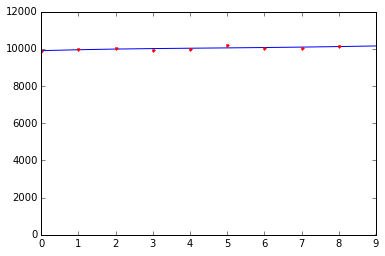

In [49]:
n = len(dataset_0.time_series)
plt.plot( xrange(n), res['poly']( xrange(n)) )
plt.hold( True )
plt.plot( xrange(n), dataset_0.time_series, 'r.' )

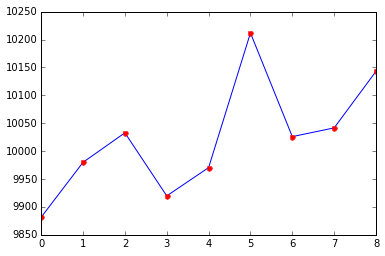

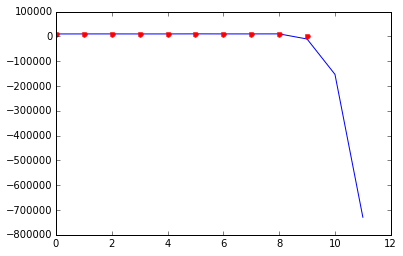

In [61]:
alg_pf8 = PolyFitAlg( 8 )
frac8,res8 = alg_pf8( dataset_0.time_series[-1], dataset_0.time_series[:-1] )
n = len(dataset_0.time_series)
plt.figure()
plt.plot( xrange(n-1), res8['poly']( xrange(n-1)) )
plt.hold( True )
plt.plot( xrange(n-1), dataset_0.time_series[:-1], 'r.', ms=10 )
plt.figure()
plt.plot( xrange(n + 2), res8['poly']( xrange(n + 2)) )
plt.hold( True )
plt.plot( xrange(n), dataset_0.time_series, 'r.', ms=10 )

# Mean-Square Error as Measure of Fit

In [62]:
## compute the mean squared error for a history and a PolyFit algorithm
def polyfit_mse( alg, history ):
    # first fit the algorithm with a dummy target
    frac, res = alg( history[-1], history )
    
    # ok, grab polynomial from fit and compute errors
    poly = res['poly']
    x = xrange(len(history))
    errors = np.array(history) - poly(x)
    
    # compute mean squared error
    mse = np.mean( errors * errors.transpose() )
    return mse

In [64]:
mse_pf4 = polyfit_mse( alg_pf, dataset_0.time_series[:-1] )
mse_pf8 = polyfit_mse( alg_pf8, dataset_0.time_series[:-1] )
print "order 4 MSE: {0}".format( mse_pf4 )
print "order 8 MSE: {0}".format( mse_pf8 )

order 4 MSE: 5192.24159236
order 8 MSE: 8.60447610975e-19


# Best Historical MSE = Best Future Performance?

In [74]:
run_spec_pf4 = time_series.result_set.RunSpec( time_series.generated_datasets.DSS[0], alg_pf)
run_spec_pf8 = time_series.result_set.RunSpec( time_series.generated_datasets.DSS[0], alg_pf8)
rset_pf4 = run_spec_pf4.collect_results( 20, 5, 9 )
rset_pf8 = run_spec_pf8.collect_results( 20, 5, 9 )
stats_pf4 = time_series.result_set.compute_classifier_stats( rset_pf4, 0.5 )
stats_pf8 = time_series.result_set.compute_classifier_stats( rset_pf8, 0.5 )
print "order 4 stats: {0}".format( stats_pf4 )
print "order 8 stats: {0}".format( stats_pf8 )

order 4 stats: {'tn': 45.0, 'fp': 0.0, 'fn': 0.0, 'recall': 1.0, 'fall_out': 0.0, 'precision': 1.0, 'tp': 5.0, 'accuracy': 1.0}
order 8 stats: {'tn': 42.0, 'fp': 3.0, 'fn': 0.0, 'recall': 1.0, 'fall_out': 0.06666666666666667, 'precision': 0.625, 'tp': 5.0, 'accuracy': 0.94}


# Overfitting!
So what now?  This is where we use all of the methods for preventing overfitting:
  - Cross-validation based model selection
  - AIC/BIC all those information criteria which weight model fit versus moder complexity
  - Algorithm Stability ( stability == generalizability )
  - Statistical Learning Theory to learn using Structures (Structure Learning Theory)
  - Choose a better performance criteria than historical fit